# Hospitalizations as a function of traffic in NYC


In this project, I plan to explore the relationship between social distance and Covid-19 related hospitalizations in New York City during the last 4 months.
For this, I will try to quantify the amount of social distancing using tomtom's traffic index. Tomtom's traffic index is the percentage of extra time that it takes to travel any given day based on some baseline(no traffic). 

I will use this to create a daily traffic social distance (TSD) index that will reflect the change in congestion with respect to a normal traffic day. I will use the first week of February as my baseline traffic congestion. I will divide each day of the daily traffic index by the corresponding day in the base week. To smooth the data I will use a 7-day moving average.

This will give me an index where 0 indicates maximum TSD (no traffic), 1 indicates no TSD (same traffic as baseline). TSD greater than 1 indicate more traffic than usual.

Hospitalization data comes from [New York's City health webpage](https://www1.nyc.gov/site/doh/covid/covid-19-data.page). The dataset contains daily hospitalization numbers related to Covid_19 in NYC. To smooth the volatility of the hospitalization data I use a 7-day moving average. Then I find the day to day change to approximate the rate of hospital admissions.






## Importing libraries and files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from datetime import date


In [2]:
h_df = pd.read_csv('../Data/hospitalizations.csv', index_col='DATE_OF_INTEREST', parse_dates=True)
t_df = pd.read_csv('../Data/NewYork_traffic.csv', index_col='Date', parse_dates= True)

# MTA data for sumbway and bus usage. 
#b_df = pd.read_csv('../Data/buses_ridership.csv', index_col='Date', parse_dates=True)
#s_df = pd.read_csv('../Data/Subway_ridership.csv', index_col='Date', parse_dates=True )

## Hospitalization Data

In [3]:
h_df.head(3)

,Cases,Hospitalizations,Deaths
DATE_OF_INTEREST,,,
2020-02-29,1,11,0
2020-03-01,1,4,0
2020-03-02,0,22,0


### Feature Engineering  

In [4]:
# trying a log transformatin of hospitalizations
h_df['log_hosp'] = np.log(h_df['Hospitalizations'])

In [5]:
h_df.tail(2)

,Cases,Hospitalizations,Deaths,log_hosp
DATE_OF_INTEREST,,,,
2020-06-24,186,30,15,3.401197
2020-06-25,143,27,7,3.295837


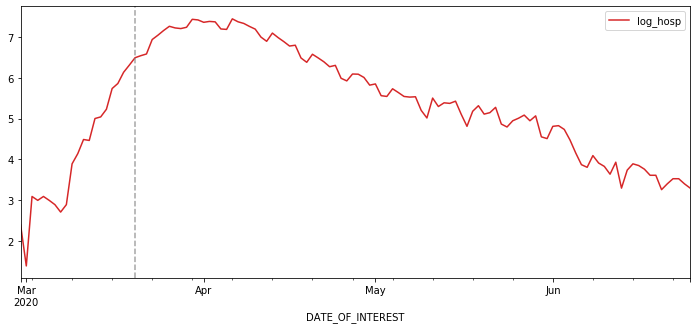

In [6]:
ax = h_df[['log_hosp']].plot(figsize=(12,5), color='C3');
# Dashed line shows March 20th the date New York when officialy into PAUSE.
ax.axvline(x=date(2020, 3, 20), color='C7', alpha=0.7,linestyle='dashed');

### Trying a rolling growth rate

In [7]:

h_df['hosp_rolling'] = h_df['Hospitalizations'].rolling(window=3).mean()
h_df['hosp_rolling_7'] = h_df['Hospitalizations'].rolling(window=7).mean()

h_df['log_hosp_rolling'] = h_df['log_hosp'].rolling(window=3).mean()
h_df['log_hosp_rolling_7'] = h_df['log_hosp'].rolling(window=7).mean()
#rates
h_df['hosp_rate'] = h_df['log_hosp_rolling']/h_df['log_hosp_rolling_7'] 
h_df['log_hosp_rate'] = np.log(h_df['hosp_rolling'])/np.log(h_df['hosp_rolling_7'])

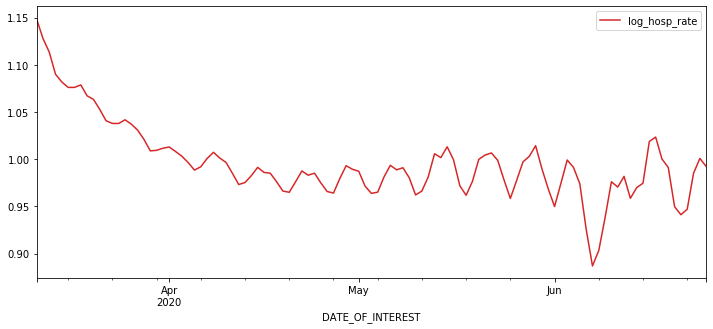

In [8]:
h_df[['log_hosp_rate']][11:].plot(figsize=(12,5), color='C3');

### hosp_change
I create a hospitalization index by finding the daily percentage of change in the 7-day rolling hospitalization numbers.

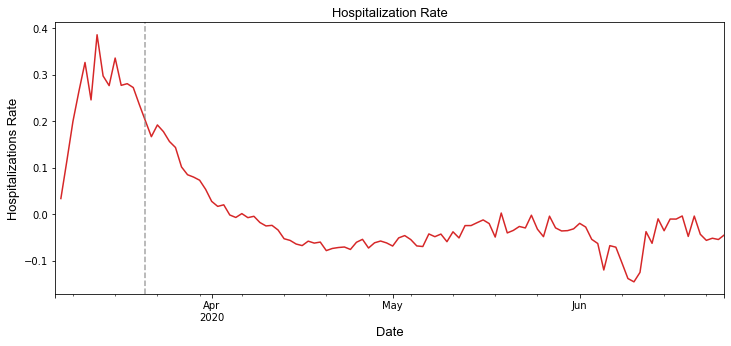

In [9]:
# Percentage change between the current and a prior element.
h_df['hosp_change'] =h_df[['hosp_rolling_7']].pct_change()

#plot font
font = {'family': 'arial','weight': 'normal','size': 13,}

# plot of the change in daily change in hospitalizatios
ax = h_df['hosp_change'][6:].plot(figsize=(12,5), color='C3');
plt.xlabel('Date', fontdict=font)
plt.ylabel('Hospitalizations Rate',fontdict=font)
plt.title('Hospitalization Rate',fontdict=font)
ax.axvline(x=date(2020, 3, 21), color='C7', alpha=0.7,linestyle='dashed');

In [10]:
h_df.head(10)

,Cases,Hospitalizations,Deaths,log_hosp,hosp_rolling,hosp_rolling_7,log_hosp_rolling,log_hosp_rolling_7,hosp_rate,log_hosp_rate,hosp_change
DATE_OF_INTEREST,,,,,,,,,,,
2020-02-29,1,11,0,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,1,4,0,1.386294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,0,22,0,3.091042,12.333333,NaN,2.291744,NaN,NaN,NaN,NaN
2020-03-03,2,20,0,2.995732,15.333333,NaN,2.491023,NaN,NaN,NaN,NaN
2020-03-04,5,22,0,3.091042,21.333333,NaN,3.059272,NaN,NaN,NaN,NaN
2020-03-05,3,20,0,2.995732,20.666667,NaN,3.027502,NaN,NaN,NaN,NaN
2020-03-06,8,18,0,2.890372,20.000000,16.714286,2.992382,2.692587,1.111341,1.063726,NaN
2020-03-07,7,15,0,2.708050,17.666667,17.285714,2.864718,2.736895,1.046704,1.007649,0.034188
2020-03-08,21,18,0,2.890372,17.000000,19.285714,2.829598,2.951763,0.958613,0.957372,0.115702


## Social distance - Traffic index

In [11]:
t_df.tail()

,trafic_index,first week of February
Date,,
2020-06-23,16,28
2020-06-24,16,28
2020-06-25,17,37
2020-06-26,19,34
2020-06-27,10,18


### Feature Engineering 

I use the first week of February as my baseline traffic congestion. I divide each day of the daily traffic index by the corresponding day in the base week.

In [12]:
t_df['TSD'] = t_df['trafic_index']/t_df['first week of February']

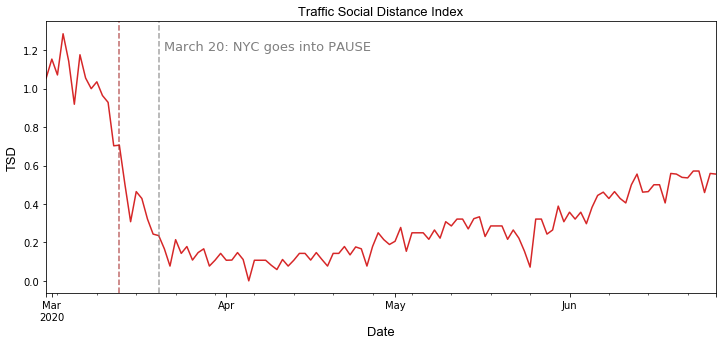

In [13]:
ax = t_df['TSD'].plot(figsize=(12,5), color='C3');
plt.xlabel('Date',fontdict=font)
plt.ylabel('TSD',fontdict=font)
plt.title('Traffic Social Distance Index',fontdict=font)
plt.text(date(2020, 3, 21), 1.2, 'March 20: NYC goes into PAUSE', color= 'C7', fontsize =13)
ax.axvline(x=date(2020, 3, 13), color='brown', alpha=0.7,linestyle='dashed')
ax.axvline(x=date(2020, 3, 20), color='C7', alpha=0.7,linestyle='dashed');

To smooth the data I use a 7-day moving average.

In [14]:
t_df['TSD_rolling'] = t_df['TSD'].rolling(window=7).mean()

Text(2020-05-26, 0.8, 'Memorial Day')

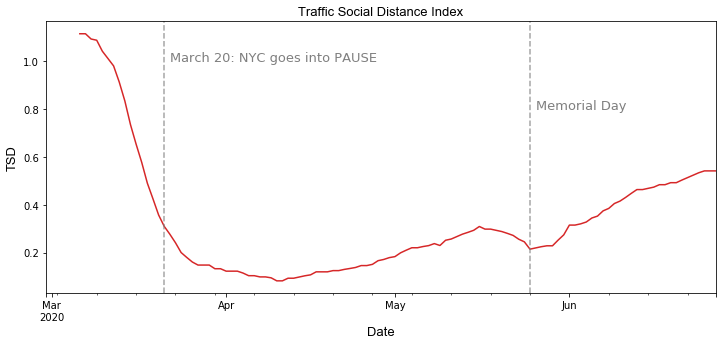

In [16]:
ax = t_df['TSD_rolling'].plot(figsize=(12,5), color='C3');
plt.xlabel('Date',fontdict=font)
plt.ylabel('TSD',fontdict=font)
plt.title('Traffic Social Distance Index',fontdict=font)
ax.axvline(x=date(2020, 3, 21), color='C7', alpha=0.7, linestyle='dashed');
plt.text(date(2020, 3, 22), 1, 'March 20: NYC goes into PAUSE', color= 'C7', fontsize =13)
ax.axvline(x=date(2020, 5, 25), color='C7', alpha=0.7, linestyle='dashed');
plt.text(date(2020, 5, 26), .8, 'Memorial Day', color= 'C7', fontsize =13)
#ax.axvline(x=date(2020, 3, 13), color='brown', alpha=0.7,linestyle='dashed');

In [17]:
def diff_series(df, col, lag):
    """Function that lags the value of a colun given the dataframe the name of the 
    column by a number of lags"""
    for i in range(0,lag,1):
        new_col = col+f'_lag_{i+1}'
        df[new_col] = df[col].shift(i+1)
    

In [18]:
diff_series(t_df, 'TSD_rolling', 30)

In [19]:
t_df.head(15)

,trafic_index,first week of February,TSD,TSD_rolling,TSD_rolling_lag_1,TSD_rolling_lag_2,TSD_rolling_lag_3,TSD_rolling_lag_4,TSD_rolling_lag_5,TSD_rolling_lag_6,...,TSD_rolling_lag_21,TSD_rolling_lag_22,TSD_rolling_lag_23,TSD_rolling_lag_24,TSD_rolling_lag_25,TSD_rolling_lag_26,TSD_rolling_lag_27,TSD_rolling_lag_28,TSD_rolling_lag_29,TSD_rolling_lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-29,19,18,1.055556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,15,13,1.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,30,28,1.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,36,28,1.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,32,28,1.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,34,37,0.918919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,40,34,1.176471,1.114970,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,19,18,1.055556,1.114970,1.114970,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,13,13,1.000000,1.092992,1.114970,1.114970,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# There are two extra dates for traffic data
h_df['hosp_change'].shape, t_df['TSD_rolling_lag_14'].shape

((118,), (120,))

## Linear  regression model

I fit a simple linear model using the traffic social distance `'TSD_rolling'` as a predictor of Hospitalization's percentage growth `'hosp_change'` and test the $R^{2}$ at differest lags.

In [21]:
def lag_finder(n):
    """Returns the rsquare(R^2) of each of the OLS model for TSD_rolling column lag up to
    n times"""
    rsquared =[]
    for i in range(1,n):
        # slice because the nan generated with creating the rolling mean
        # and because there are two extra days of TSD data t_df[6:-2] = h_df[6:]
        X = sm.add_constant(t_df[f'TSD_rolling_lag_{i}'][6+i:-2])
        model = sm.OLS(h_df['hosp_change'][6+i:],X)
        results = model.fit()
        rsquared.append(results.rsquared)
    return rsquared
        

/Users/flatironschool/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


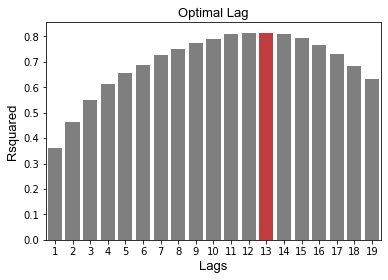

In [22]:
# fitting OLS regression on 20 lags
rsqr = lag_finder(20)
lag = list(range(1,20))

# Makes red the highest column
clrs = ['C7' if (x < max(rsqr)) else 'C3' for x in rsqr ]
ax = sns.barplot(x=lag, y=rsqr, palette=clrs) 
plt.xlabel('Lags',fontdict=font)
plt.ylabel('Rsquared',fontdict=font)
plt.title("Optimal Lag",fontdict=font);

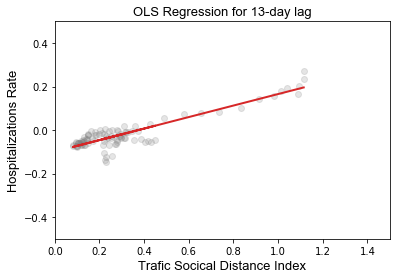

In [23]:
#Exploring optimal lag
X = sm.add_constant(t_df['TSD_rolling_lag_13'][19:-2])
model = sm.OLS(h_df['hosp_change'][19:],X)
results = model.fit()

plt.scatter(t_df['TSD_rolling_lag_13'][:-2],h_df['hosp_change'],alpha=0.2, color='C7')
y_predict = results.params[0] + results.params[1]*t_df['TSD_rolling_lag_13'][:-2]
plt.plot(t_df['TSD_rolling_lag_13'][:-2],y_predict, linewidth=2, color='C3')
plt.xlim(0,1.5)
plt.ylim(-0.5,0.5)
plt.xlabel('Trafic Socical Distance Index',fontdict=font)
plt.ylabel('Hospitalizations Rate',fontdict=font)
plt.title('OLS Regression for 13-day lag',fontdict=font);

In [24]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            hosp_change   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     426.6
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           2.74e-37
Time:                        12:33:03   Log-Likelihood:                 198.88
No. Observations:                  99   AIC:                            -393.8
Df Residuals:                      97   BIC:                            -388.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0989      0

## Arimax model

In [25]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima  

import warnings
warnings.filterwarnings("ignore")

In [26]:
t_df.columns

Index(['trafic_index', 'first week of February', 'TSD', 'TSD_rolling',
       'TSD_rolling_lag_1', 'TSD_rolling_lag_2', 'TSD_rolling_lag_3',
       'TSD_rolling_lag_4', 'TSD_rolling_lag_5', 'TSD_rolling_lag_6',
       'TSD_rolling_lag_7', 'TSD_rolling_lag_8', 'TSD_rolling_lag_9',
       'TSD_rolling_lag_10', 'TSD_rolling_lag_11', 'TSD_rolling_lag_12',
       'TSD_rolling_lag_13', 'TSD_rolling_lag_14', 'TSD_rolling_lag_15',
       'TSD_rolling_lag_16', 'TSD_rolling_lag_17', 'TSD_rolling_lag_18',
       'TSD_rolling_lag_19', 'TSD_rolling_lag_20', 'TSD_rolling_lag_21',
       'TSD_rolling_lag_22', 'TSD_rolling_lag_23', 'TSD_rolling_lag_24',
       'TSD_rolling_lag_25', 'TSD_rolling_lag_26', 'TSD_rolling_lag_27',
       'TSD_rolling_lag_28', 'TSD_rolling_lag_29', 'TSD_rolling_lag_30'],
      dtype='object')

In [27]:
arima_df= pd.DataFrame.join(h_df[['hosp_change']][7:], t_df[['TSD_rolling',
       'TSD_rolling_lag_10', 'TSD_rolling_lag_11', 'TSD_rolling_lag_12',
       'TSD_rolling_lag_13', 'TSD_rolling_lag_14', 'TSD_rolling_lag_15',]][7:-2], 
                            on=None, how='left', lsuffix='', rsuffix='', sort=False)

In [29]:
arima_df.tail(3)

,hosp_change,TSD_rolling,TSD_rolling_lag_10,TSD_rolling_lag_11,TSD_rolling_lag_12,TSD_rolling_lag_13,TSD_rolling_lag_14,TSD_rolling_lag_15
DATE_OF_INTEREST,,,,,,,,
2020-06-23,-0.051181,0.523627,0.463418,0.447545,0.430739,0.415295,0.405090,0.384682
2020-06-24,-0.053942,0.533831,0.463418,0.463418,0.447545,0.430739,0.415295,0.405090
2020-06-25,-0.043860,0.541553,0.468520,0.463418,0.463418,0.447545,0.430739,0.415295


### Checking for Stationarity 

In [31]:
from statsmodels.tsa.stattools import adfuller
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(arima_df['hosp_change'])#,regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.004672421361217997


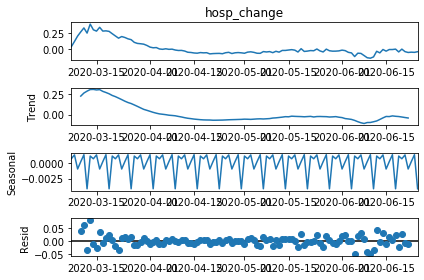

In [32]:
result = seasonal_decompose(arima_df['hosp_change'])
result.plot();

In [33]:
auto_arima(arima_df['hosp_change'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 229.346
Date:                Wed, 08 Jul 2020   AIC                           -448.693
Time:                        12:35:52   BIC                           -435.190
Sample:                             0   HQIC                          -443.216
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.318      0.751      -0.002       0.003
ar.L1          0.8372      0.062     13.447      0.000       0.715       0.959
ma.L1         -1.0772      0.084    -12.884      0.000      -1.241      -0.913
ma.L2          0.4597      0.072      6.403      0.000       0.319       0.600
sigma2         0.0009   8.72e-05     10.302      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       23.60   Jarque-Bera (JB):                69.84
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.12
Prob(H) (two-sided):                  0.16   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
#train test split
test_size =7
train, test = arima_df[13:-test_size], arima_df[-test_size:]

In [35]:
model = SARIMAX(train['hosp_change'],order=(3,1,0),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            hosp_change   No. Observations:                   91
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 216.356
Date:                Wed, 08 Jul 2020   AIC                           -424.711
Time:                        12:36:59   BIC                           -414.712
Sample:                    03-20-2020   HQIC                          -420.679
                         - 06-18-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1892      0.096     -1.963      0.050      -0.378      -0.000
ar.L2          0.0836      0.091      0.917      0.359      -0.095       0.262
ar.L3          0.0218      0.099      0.221      0.825      -0.172       0.215
sigma2         0.0005    5.2e-05      9.182      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       41.02   Jarque-Bera (JB):                56.50
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                             0.95
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA Prediction')

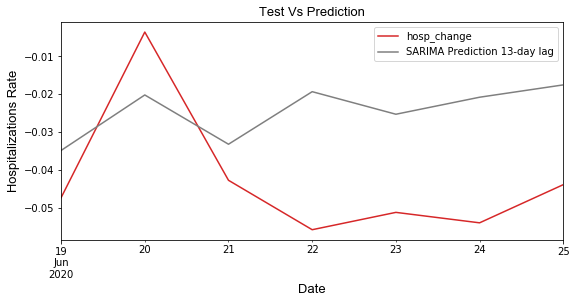

In [77]:
ax = test['hosp_change'].plot(legend=True,figsize=(9,4), color='C3')
predictions.plot(legend=True, color='C7')
ax.autoscale(axis='x',tight=True)
plt.xlabel('Date',fontdict=font)
plt.ylabel('Hospitalizations Rate',fontdict=font)
plt.title('Test Vs Prediction',fontdict=font);

In [39]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions2 = results.get_prediction(start=start, end=end, dynamic=False)

In [40]:
predict_auto = predictions2.summary_frame(alpha=0.10)

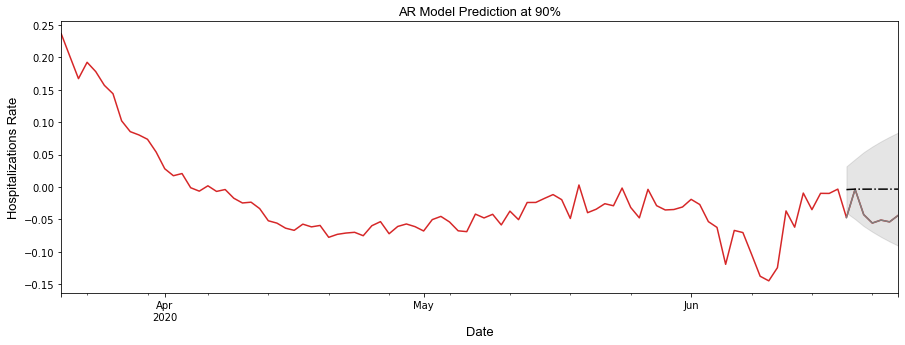

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
arima_df['hosp_change'][13:111].plot(ax=ax, color='C3')
test['hosp_change'].plot(ax=ax, color='C7')
predict_auto['mean'].plot(ax=ax, style='k-.')
ax.fill_between(predict_auto.index, predict_auto['mean_ci_lower'], predict_auto['mean_ci_upper'], color='k', alpha=0.10);
plt.xlabel('Date',fontdict=font)
plt.ylabel('Hospitalizations Rate',fontdict=font)
plt.title('AR Model Prediction at 90%',fontdict=font);

In [45]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


error = mean_squared_error(test['hosp_change'], predictions)
print(f'ARIMA(3,1,0) MSE Error: {error:11.10}')

error = rmse(test['hosp_change'], predictions)
print(f'ARIMA(3,1,0) RMSE Error: {error:11.10}')

ARIMA(3,1,0) MSE Error: 0.001804441406
ARIMA(3,1,0) RMSE Error: 0.04247871709


### Adding exogenos variable

In [46]:
auto_arima(arima_df['hosp_change'], exogenous=arima_df[['TSD_rolling']],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 230.265
Date:                Wed, 08 Jul 2020   AIC                           -448.529
Time:                        12:41:57   BIC                           -432.327
Sample:                    03-07-2020   HQIC                          -441.957
                         - 06-25-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0011      0.003      0.324      0.746      -0.006       0.008
TSD_rolling     0.1640      0.153      1.074      0.283      -0.135       0.463
ar.L1          -0.2073      0.053     -3.905      0.000      -0.311      -0.103
ar.L2           0.3037      0.070      4.308      0.000       0.166       0.442
ar.L3           0.3325      0.075      4.417      0.000       0.185       0.480
sigma2          0.0009   8.69e-05     10.193      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       21.74   Jarque-Bera (JB):                48.17
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.50
Prob(H) (two-sided):                  0.23   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#train test split
test_size =7
train, test = arima_df[:-test_size], arima_df[-test_size:]

In [49]:
model = SARIMAX(train[['hosp_change']],exog=train[['TSD_rolling']],order=(3,1,0),seasonal_order=(0,0,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            hosp_change   No. Observations:                  104
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 214.845
Date:                Wed, 08 Jul 2020   AIC                           -419.691
Time:                        12:42:17   BIC                           -406.517
Sample:                    03-07-2020   HQIC                          -414.355
                         - 06-18-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TSD_rolling     0.1838      0.163      1.125      0.261      -0.136       0.504
ar.L1          -0.1914      0.053     -3.643      0.000      -0.294      -0.088
ar.L2           0.3139      0.069      4.534      0.000       0.178       0.450
ar.L3           0.3473      0.074      4.694      0.000       0.202       0.492
sigma2          0.0009   8.04e-05     11.166      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       20.92   Jarque-Bera (JB):                50.78
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.48
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
error = mean_squared_error(test['hosp_change'], predictions)
print(f'ARIMA(3,1,0) MSE Error: {error:11.10}')

error = rmse(test['hosp_change'], predictions)
print(f'ARIMA(3,1,0) RMSE Error: {error:11.10}')

ARIMA(3,1,0) MSE Error: 0.001804441406
ARIMA(3,1,0) RMSE Error: 0.04247871709


### Adding exogenos variable 13 lag

In [51]:
auto_arima(arima_df['hosp_change'][13:], exogenous=arima_df[['TSD_rolling_lag_13']][13:],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   98
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 248.457
Date:                            Wed, 08 Jul 2020   AIC                           -484.913
Time:                                    12:42:36   BIC                           -469.465
Sample:                                03-20-2020   HQIC                          -478.667
                                     - 06-25-2020                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             -0.0007      0.001     -1.335      0.182      -0.002       0.000
TSD_rolling_lag_13     0.2307      0.039      5.916      0.000       0.154       0.307
ar.L1                  0.4109      0.150      2.735      0.006       0.116       0.705
ma.L1                 -0.7792      0.106     -7.344      0.000      -0.987      -0.571
ar.S.L7               -0.4074      0.111     -3.673      0.000      -0.625      -0.190
sigma2                 0.0003   3.96e-05      8.584      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       31.41   Jarque-Bera (JB):                11.63
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               3.75   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
#train test split
test_size =7
train, test = arima_df[13:-test_size], arima_df[-test_size:]

In [93]:
model = SARIMAX(train[['hosp_change']],exog=train[['TSD_rolling_lag_13']],order=(1,1,1),seasonal_order=(1,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        hosp_change   No. Observations:                   89
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 224.862
Date:                            Wed, 08 Jul 2020   AIC                           -439.723
Time:                                    13:08:27   BIC                           -427.337
Sample:                                03-22-2020   HQIC                          -434.733
                                     - 06-18-2020                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
TSD_rolling_lag_13     0.2303      0.051      4.515      0.000       0.130       0.330
ar.L1                  0.3363      0.233      1.444      0.149      -0.120       0.793
ma.L1                 -0.6869      0.186     -3.703      0.000      -1.051      -0.323
ar.S.L7               -0.3267      0.118     -2.780      0.005      -0.557      -0.096
sigma2                 0.0003   4.09e-05      8.526      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       33.67   Jarque-Bera (JB):                15.98
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['TSD_rolling_lag_13']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMA Prediction 13-day lag')

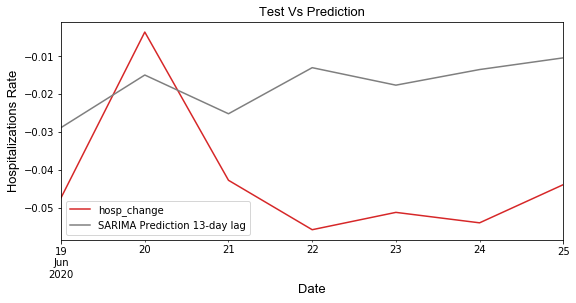

In [85]:
ax = test['hosp_change'].plot(legend=True,figsize=(9,4), color='C3')
predictions.plot(legend=True, color='C7')
ax.autoscale(axis='x',tight=True)
plt.xlabel('Date',fontdict=font)
plt.ylabel('Hospitalizations Rate',fontdict=font)
plt.title('Test Vs Prediction',fontdict=font);

In [86]:
error = mean_squared_error(test['hosp_change'], predictions)
print(f'SARIMAX(1, 1, 1)x(1, 0, 0, 7) MSE Error: {error:11.10}')

error = rmse(test['hosp_change'], predictions)
print(f'SARIMAX(1, 1, 1)x(1, 0, 0, 7) RMSE Error: {error:11.10}')

SARIMAX(1, 1, 1)x(1, 0, 0, 7) MSE Error: 0.0009290862828
SARIMAX(1, 1, 1)x(1, 0, 0, 7) RMSE Error: 0.0304809167


In [87]:
test['hosp_change'].mean()

-0.042613252129384036

In [88]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['TSD_rolling_lag_13']]
predictions2 = results.get_prediction(start=start, end=end, exog=exog_forecast)

In [89]:
predict = predictions2.summary_frame(alpha=0.10)
predict05 = predictions2.summary_frame(alpha=0.05)

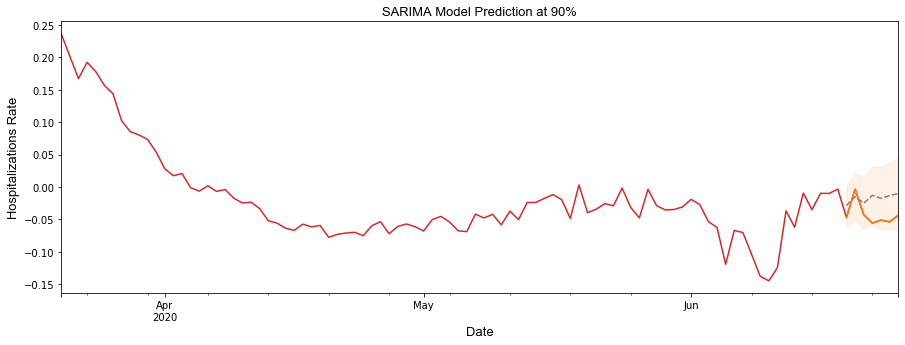

In [90]:
fig, ax = plt.subplots(figsize=(15, 5))
arima_df['hosp_change'][13:111].plot(ax=ax, color='C3')
test['hosp_change'].plot(ax=ax, color='C1')
predict['mean'].plot(ax=ax, style='--',color ='C7')
ax.fill_between(predict.index, predict['mean_ci_lower'], predict['mean_ci_upper'], color='C1', alpha=.1);
plt.xlabel('Date',fontdict=font)
plt.ylabel('Hospitalizations Rate',fontdict=font)
plt.title('SARIMA Model Prediction at 90%',fontdict=font);

## Var Model

In [ ]:

var_df= pd.concat([h_df['hosp_change'], t_df['TSD_rolling']], axis=1)

In [ ]:
var_df.head(2)

In [ ]:
var_df[7:-2].plot();

In [ ]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(var_df['hosp_change'][7:-2])#,regression='ct')
print('p-value:{}'.format(res[1]))

In [ ]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(var_df['TSD_rolling'][7:-2])#,regression='ct')
print('p-value:{}'.format(res[1]))

In [ ]:
trans_df = var_df.diff().dropna()

In [ ]:
#ADF-test(Differenced-time-series)
res = sm.tsa.adfuller(trans_df['hosp_change'][7:-2])#,regression='ct')
print('p-value:{}'.format(res[1]))


In [ ]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(trans_df['TSD_rolling'][7:-2])#,regression='ct')
print('p-value:{}'.format(res[1]))

In [ ]:
trans_df.plot();

In [ ]:
trans2_df = trans_df.diff().dropna()

In [ ]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(trans2_df['hosp_change'][7:-2])#,regression='ct')
print('p-value:{}'.format(res[1]))


In [ ]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(trans2_df['TSD_rolling'][7:-2])#,regression='ct')
print('p-value:{}'.format(res[1]))

In [ ]:
test_size =7 
train, test = trans2_df[:-test_size], trans2_df[-test_size:]

In [ ]:
train.shape, test.shape


In [ ]:
# Load specific forecasting tools
from statsmodels.tsa.api import VAR

In [ ]:
for i in range(20):
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

In [ ]:
results = model.fit(16)
results.summary()

### granger causality tests

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(trans_df, maxlag = 20, verbose=True)

In [ ]:
grangercausalitytests(var_df.dropna(), maxlag = 20, verbose=True)

In [ ]:
z = results.forecast(y=train.values[-16:], steps=7)

In [ ]:
idx = pd.date_range('2020-06-19', periods=7, freq='D')
idx

In [ ]:
test.head(10)

In [ ]:
forcast_df = pd.DataFrame(data=z, index=idx, columns=['hosp_change_2d','TSD_rolling_2d'])

In [ ]:
forcast_df

In [ ]:
test

In [ ]:
forcast_df['hosp_change_1d'] = (var_df['hosp_change'].iloc[-test_size-1]-
                                var_df['hosp_change'].iloc[-test_size-2])+ forcast_df['hosp_change_2d'].cumsum()


In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()